In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Метрики в машинном обучении нужны для того, чтобы оценивать качество работы модели, чтобы понимать, а насколько модель хорошо запомнила закономерности из обучающей выборки.

Сегодня будем рассматривать метрики для задачи классификации - предсказания номинативной (качественной) целевой переменной. Для такой задачи хочется, чтобы наши модели как можно чаще предсказывали верную метку класса объекта.

<img src='https://static.javatpoint.com/tutorial/machine-learning/images/classification-algorithm-in-machine-learning.png' width=600>


Для подсчета разных метрик классификации сгенерируем данные с помощью `sklearn`.

**Генарация данных**

In [2]:
from sklearn import datasets

In [3]:
X, y = datasets.make_classification(
    # выборка будет состоять из
    n_samples=20, # 20 штук объектов
    n_features=2, # из 2-х признаков
    n_informative=2, # 2 из которых информативны
    n_redundant=0, # и ни одного бесполезного
    n_classes=2, # предсказываем целевую переменную, которая будет состоять из 2-х классов
    random_state=2)

Получили 20 объектов из двух признаков, можем их визуализировать и сделать раскрашивание в зависимости от метки класса:

**Обучение модели**

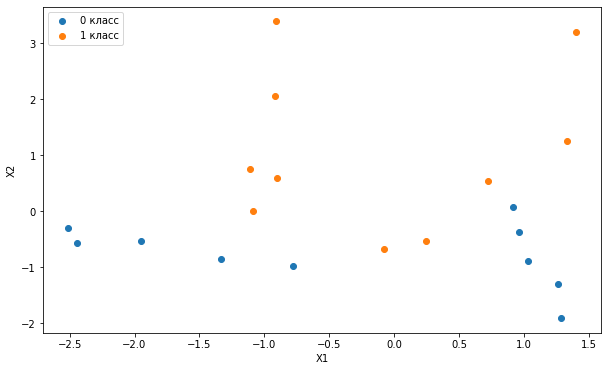

In [9]:
plt.figure(figsize=(10, 6))

class_0 = X[y == 0]
class_1 = X[y == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], label='0 класс')
plt.scatter(class_1[:, 0], class_1[:, 1], label='1 класс')

plt.legend()
plt.xlabel('X1')
plt.ylabel('X2');

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)

LogisticRegression()

**Предскажем модель на всех данных, чтобы понять, насколько хорошо наша модель научилась предсказывать целевую переменную**

In [12]:
pred = logreg.predict(X)

Выведем рядом истинные значения целевой переменной и предсказанные моделью классы

In [16]:
pred_df = pd.DataFrame({'y_true':y,'y_pred':pred})
pred_df['right'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

,y_true,y_pred,right
0,1,0,False
1,0,0,True
2,1,0,False
3,1,1,True
4,1,1,True
5,1,1,True
6,0,0,True
7,0,0,True
8,1,1,True
9,1,0,False


Если сравним истину с предасказанным классом, то узнаем сколько раз модель ответила правильно - это и есть наша первая метрика Accuracy.


Это наиболее очевидный и простой способ расчета качества предсказаний:

$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$


Доля правильных ответов может изменяться от 0 до 1, где 0 - модель ни разу не попала правильно, все её предсказания ошибочные, а 1 - модель предсказала всё идеально.

Найдем объекты, на которых модель ошиблась:

In [19]:
wrong_objects_0_class = X[~(pred_df.right)&(pred_df.y_true.eq(0))]
wrong_objects_1_class = X[~(pred_df.right)&(pred_df.y_true.eq(1))]

И визуализируем, пометив зеленым цветом объекты 1 класса, на которых модель ошибочно сделала предсказания нулевого класса и красным цветом - объекты 0 класса, которые модель ошибочно отнесла к 1 классу.

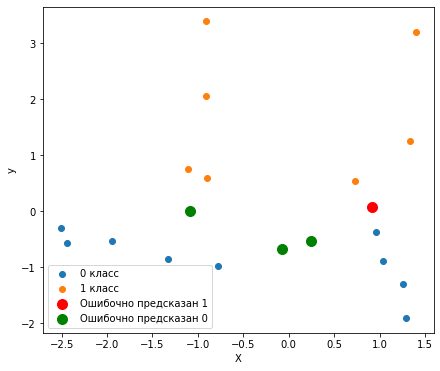

In [20]:
plt.figure(figsize=(7, 6))

# визуализация данных по классам
class_0 = X[y == 0]
class_1 = X[y == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], label='0 класс')
plt.scatter(class_1[:, 0], class_1[:, 1], label='1 класс')

# визуализация ошибок по классам
plt.scatter(wrong_objects_0_class[:, 0], wrong_objects_0_class[:, 1], c='r', label='Ошибочно предсказан 1', s=100)
plt.scatter(wrong_objects_1_class[:, 0], wrong_objects_1_class[:, 1], c='g', label='Ошибочно предсказан 0', s=100)

plt.legend()
plt.xlabel('X')
plt.ylabel('y');

Ошибок вышло 4 штуки.
Посчитаем, сколько раз модель сделала верное предсказание:

In [21]:
pred_df[pred_df['right']].shape[0]

16

Посчитаем долю правильно предсказанных в общем количестве предсказаний

In [32]:
pred_df['right'].sum()/pred_df.shape[0]

0.8

Либо можем воспользоваться реализацией `sklearn'a`:

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(pred_df['y_true'], pred_df['y_pred'])

0.8

Получили 0.8 или 80% - доля верных предсказаний относительно всех предсказаний.

Метрика accuracy хорошая, простая, но у неё есть пара проблем.

### Дисбаланс классов

Представим, что в нашей выборке очень много объектов нулевого класса и совсем ничего объектов первого класса, к тому же такое встречается очень часто, примером служит задача предсказания мошеннических транзакций, или она ещё называется fraud detection: очень много совершается обычных транзакций и крайне мало транзакций со злым умыслом.

Сгенерируем такую выборку, где есть дисбаланс классов, объектов 0 класса в 9 раз больше, чем объектов 1 класса (`weights=(0.9, 0.1)`).  
Для простоты понимания, будем считать, что 0 класс - это обычные транзакции в банке, а 1 класс - это подозрительные мошеннические транзакции.

In [39]:
from sklearn import datasets


X_disbalance, y_disbalance = datasets.make_classification(
    n_samples=20,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state = 2,
    weights=(0.9, 0.1)
)

X_disbalance, y_disbalance

(array([[ 0.66930255, -0.35556485],
        [ 0.96417816, -0.37583852],
        [-1.1177634 , -0.85116212],
        [-0.26257856, -1.50684503],
        [ 1.27004352, -2.01184296],
        [ 0.72576002,  0.53047004],
        [-0.77546276, -0.9788468 ],
        [ 1.03317819, -0.88253973],
        [ 0.7545933 ,  1.11410377],
        [ 0.37973272,  0.79063286],
        [ 1.2610877 , -1.3003902 ],
        [-2.44391337, -0.56099989],
        [-0.66010918, -1.0843706 ],
        [-0.90474756,  0.59452911],
        [-2.51019507, -0.30991259],
        [ 0.9153728 ,  0.08016006],
        [ 1.28700068, -1.90827144],
        [-1.94625628, -0.53314708],
        [-0.85711456, -1.16420714],
        [-1.33222706, -0.85982898]]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))

Получили 20 объектов, где 18 - объекты нулевого класса (нормальная транзакция) и только 2 объекта первого класса (мошенническая транзакция), визуализируем:

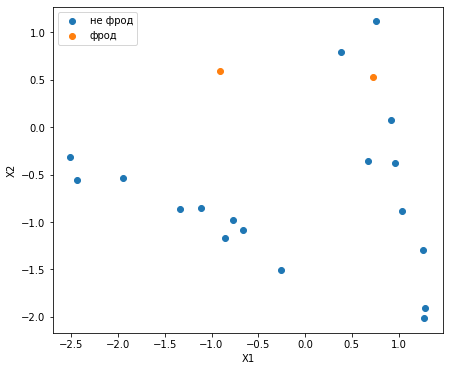

In [40]:
plt.figure(figsize=(7, 6))

class_0 = X_disbalance[y_disbalance == 0]
class_1 = X_disbalance[y_disbalance == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], label='не фрод')
plt.scatter(class_1[:, 0], class_1[:, 1], label='фрод')

plt.legend()
plt.xlabel('X1')
plt.ylabel('X2');

Если мы возьмем константную модель (a(x) = 0), которая всегда будет отвечать 0 класс на любой объект, который бы не видела, то получим приличную метрику accuracy:

In [41]:
pred = [0 for i in X_disbalance]
pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
pred_df_disbalance = pd.DataFrame({
    'y_true': y_disbalance,
    'y_pred': pred
})

pred_df_disbalance

,y_true,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,0,0
9,0,0


Сделаем новый столбец в датафрейме, который будет показывать, угадала ли наша модель истинный класс, False - если предсказание неправильное и True - если правильное:

In [43]:
pred_df_disbalance['right'] = pred_df_disbalance['y_true']==pred_df_disbalance['y_pred']

Далее можем посчитать долю правильных ответов (количество значений True поделить на количество объектов):

In [44]:
pred_df_disbalance['right'].sum()/pred_df_disbalance.shape[0]

0.9

Получается очень высокая доля правильных ответов, которая стремится к 1, но по факту, модель бесполезная, алгоритм отвечает всегда нулевым классом, модель никогда не будет отвечать первым классом. Так что метрика accuracy хоть и высокая, но говорить о качественной модели мы здесь не можем.

Найдем объекты, на которых модель ошиблась:

In [45]:
wrong_objects_0_class = X_disbalance[~(pred_df_disbalance.right)&(pred_df_disbalance.y_true.eq(0))]
wrong_objects_1_class = X_disbalance[~(pred_df_disbalance.right)&(pred_df_disbalance.y_true.eq(1))]

И визуализируем, пометив зеленым цветом - объекты с мошеннической транзакцией, которые наша константная модель ошибочно отнесла к классу нормальной не фродовой транзакции

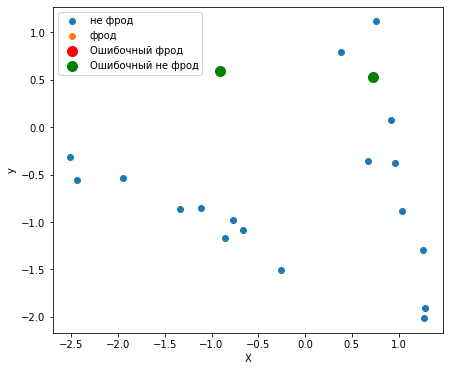

In [46]:
plt.figure(figsize=(7, 6))

# визуализация данных по классам
class_0 = X_disbalance[y_disbalance == 0]
class_1 = X_disbalance[y_disbalance == 1]
plt.scatter(class_0[:, 0], class_0[:, 1], label='не фрод')
plt.scatter(class_1[:, 0], class_1[:, 1], label='фрод')

# визуализация ошибок по классам
plt.scatter(wrong_objects_0_class[:, 0], wrong_objects_0_class[:, 1], c='r', label='Ошибочный фрод', s=100)
plt.scatter(wrong_objects_1_class[:, 0], wrong_objects_1_class[:, 1], c='g', label='Ошибочный не фрод', s=100)

plt.legend()
plt.xlabel('X')
plt.ylabel('y');

Ошибок вышло 2 штуки, ни одну мошенническую транзакцию мы так и не нашли, а соответственно даже и не помогли банку.

### Ошибки имеют разную цену

Теперь поговорим про другую проблему метрики accuracy. Продолжаем знакомиться с задачами банков, обучили модель кредитного скоринга, с помощью неё, банк принимает решение о выдачи кредита человеку.
Модель предсказывает, кому кредит выдавать (добропорядочный гражданин и будет исправно платить), а кому нет (человек постоянно просрачивает платежи по кредиту).

У нас вышло две модели, протестируем их работу на 10 клиентах.

0 будем помечать клиентов, которые кредит не вернут, а 1 - которые вернут. Предсказания моделей соответственно так же, 0 - модель предсказывает не возврат кредита, значит кредит не выдаем, а 1 - клиент кредит выплатит, значит можем быть в нём уверенными и выдаем ему деньги.

In [47]:
clients = [0, 0, 0, 0, 0, 
           1, 1, 1, 1, 1]
first_model_pred = [0, 0, 1, 1, 1,
                    1, 1, 1, 1, 1]
second_model_pred = [0, 0, 0, 0, 0,
                     1, 1, 0, 0, 0]

df = pd.DataFrame({
    'clients': clients,
    'first_model': first_model_pred,
    'second_model': second_model_pred
})

df

,clients,first_model,second_model
0,0,0,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,1,1,1
6,1,1,1
7,1,1,0
8,1,1,0
9,1,1,0


Выборка сбалансированная, 5 клиентов имеют класс 0, а 5 имеют класс 1. Посмотрим на предсказания моделей:

1. Первая выдает кредит 8 людям, по итогу 5 людей кредит возвращают, а 3 не возвращают
2. Вторая модель выдает кредит 2 людям, и все 2 возвращают.

Можете подумать, какая модель лучше? Какую модель вы бы взяли себе в банк оценивать клиентов?

На самом деле правильного ответа нет, всё зависит от стратегии банка.  
- Если банку хочется больше заработать, то лучше выдавать больше кредитов, значит, лучше пользоваться первой моделью.   
- Если банку хочется меньше потерять, то лучше выдавать кредиты только проверенным людям, а значит, лучше пользоваться второй моделью.

Но при этом, метрика accuracy будет одинаковая на этих двух моделях, хотя они совершенно разные.

In [63]:
df['first_model_right'] = df['clients'] == df['first_model']
df['second_model_right'] = df['clients'] == df['second_model']
df

,clients,first_model,second_model,first_model_right,second_model_right
0,0,0,0,True,True
1,0,0,0,True,True
2,0,1,0,False,True
3,0,1,0,False,True
4,0,1,0,False,True
5,1,1,1,True,True
6,1,1,1,True,True
7,1,1,0,True,False
8,1,1,0,True,False
9,1,1,0,True,False


In [64]:
print(f"Accuracy первой модели {df['first_model_right'].sum() / df.shape[0]}")
print(f"Accuracy второй модели {df['second_model_right'].sum() / df.shape[0]}")

Accuracy первой модели 0.7
Accuracy второй модели 0.7


Так получается из-за того, что метрика accuracy берет в расчет только правильные срабатывания на всех классах, поэтому обе модели получились одинаково хорошими по этой метрике, ведь они вдвоем дали одинаковое количество правильных ответов, по 7 штук, только вот у них были разные ошибки. Давайте их найдем.

Сначала посмотрим на ошибки первой модели:

In [65]:
# отсортируемся по ошибке в столбике first_model_right
df[~df['first_model_right']]

,clients,first_model,second_model,first_model_right,second_model_right
2,0,1,0,False,True
3,0,1,0,False,True
4,0,1,0,False,True


In [66]:
# и выведем только истинные значения и предсказания первой моделью
df[~df['first_model_right']][['clients', 'first_model']]

,clients,first_model
2,0,1
3,0,1
4,0,1


В этих трех ошибках первая модель ошибочно выдала кредит 3 людям, которые и не планировали его выплачивать.

Теперь очередь второй модели:

In [67]:
# отсортируемся по ошибке в столбике second_model_right
df[~df['second_model_right']]

,clients,first_model,second_model,first_model_right,second_model_right
7,1,1,0,True,False
8,1,1,0,True,False
9,1,1,0,True,False


In [68]:
# и выведем только истинные значения и предсказания второй моделью
df[~df['second_model_right']][['clients', 'second_model']]

,clients,second_model
7,1,0
8,1,0
9,1,0


А здесь всё наоборот. Модель не стала одобрять кредиты людям, которые были в силах всё исправно платить.

Вот они и есть разные ошибки, которые могут по-разному влиять на наши модели и на принимаемые нами решения о полезности обученных алгоритмов.

<table>

<tr>
<td>
Метрика
</td>

<td>
Формула
</td>

<td>
Диапазоны значений
</td>

<td>
Идеальное значение
</td>
</tr>

<tr>
<td>
Accuracy
</td>

<td>
$$accuracy(a,x) = \frac{1}{l} \sum^{l}_{i=1}[a(x_{i})=y_{i}].$$

</td>

<td>
[0, 1]
</td>

<td>
1
</td>
</tr>

<table>

Мы посмотрели на метрику для задачи классификации Accuracy.   
Метрика хороша для
- Начала работы над новой задачей
- Для выборок без дисбаланса классов
- Для задач, где ошибки имеют одинаковый вес